In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, BatchNormalization, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array



2024-10-23 00:02:12.786616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 00:02:12.786708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 00:02:12.788346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# I used Göker Güners notebook for a headstart so the first couple of cells are not mine.

In [3]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [4]:

label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

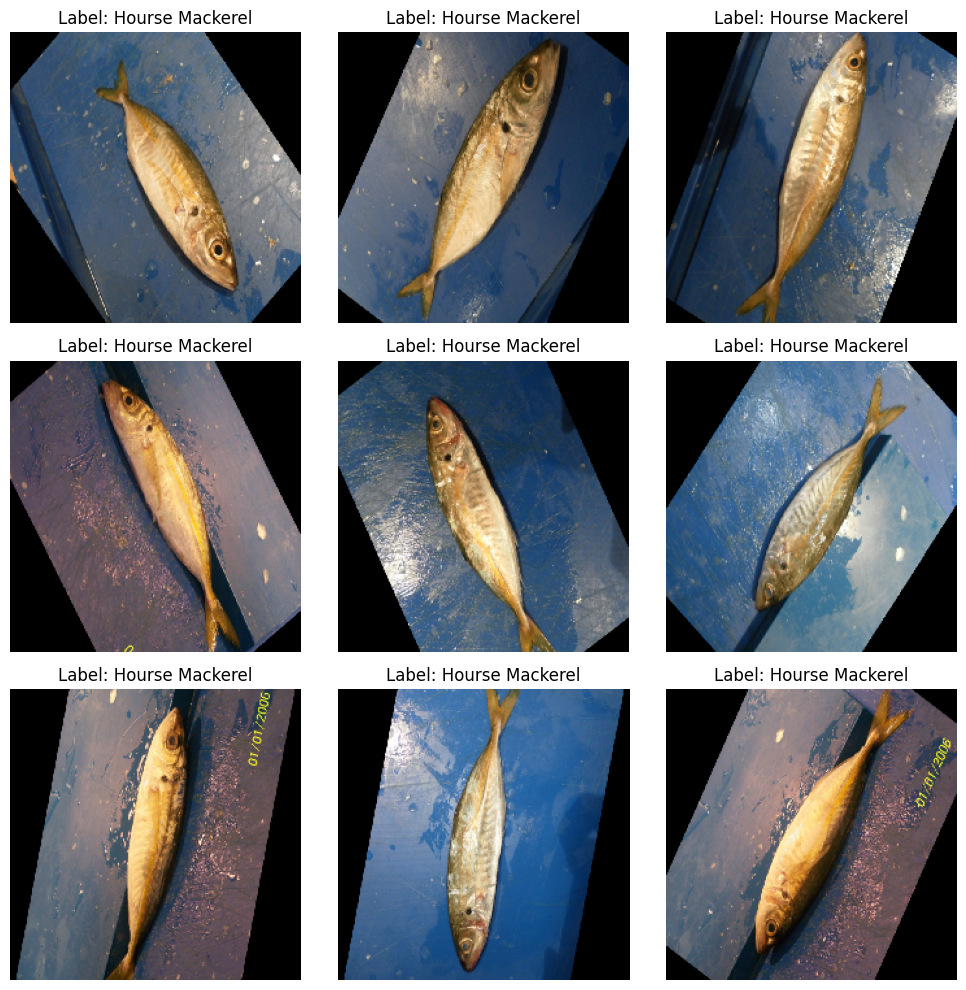

In [5]:
# İlk 9 resmi ve etiketleriyle beraber göstermek için
plt.figure(figsize=(10,10))

for i in range(9):
    # Görüntü yolu ve etiketini al
    img_path = data['path'][i]
    label = data['label'][i]
    
    # Görüntüyü yükle
    img = load_img(img_path, target_size=(224, 224))  # Görüntü boyutunu ayarla
    img_array = img_to_array(img) / 255.0  # Görüntüleri normalize et
    
    # 3x3 bir grid içinde görüntüleri yerleştir
    plt.subplot(3, 3, i+1)
    plt.imshow(img_array)
    plt.title(f'Label: {label}')
    plt.axis('off')

# Görselleri göster
plt.tight_layout()
plt.show()


In [6]:
# Veri setinin satır (row) ve sütun (column) sayısını öğrenme
num_rows, num_columns = data.shape
print(f"Veri setindeki satır sayısı: {num_rows}")
print(f"Veri setindeki sütun sayısı: {num_columns}")

# Kaç çeşit balık olduğunu öğrenme
unique_fish_species = data['label'].nunique()
print(f"Veri setindeki balık türü sayısı: {unique_fish_species}")

# Balık türlerinin isimlerini listeleme
fish_species = data['label'].unique()
print(f"Veri setindeki balık türleri: {fish_species}")


Veri setindeki satır sayısı: 9000
Veri setindeki sütun sayısı: 2
Veri setindeki balık türü sayısı: 9
Veri setindeki balık türleri: ['Hourse Mackerel' 'Black Sea Sprat' 'Sea Bass' 'Red Mullet' 'Trout'
 'Striped Red Mullet' 'Shrimp' 'Gilt-Head Bream' 'Red Sea Bream']


In [7]:
batch_size = 32
img_height = 224
img_width = 224

In [8]:
# Prepare data generators with rescaling and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)  # 20% data for validation
train_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical')

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


In [9]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

print(num_classes)

9


# This is the example from Göker Güner i didnt erase it  so we can see how much i can improve

In [10]:
# Build the ANN model
model_ann = keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Flatten(),  # Flatten the 3D image to 1D vector
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_ann.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Print model summary
model_ann.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 77236233 (294.63 MB)
Trainable params: 77236233 (294.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU(s) Available:")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPU detected. Check your installation.")

TensorFlow Version: 2.15.0
GPU(s) Available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
  - PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# FIRST EXAMPLE MODEL

In [12]:
# Train the model
with tf.device('/GPU:0'):
    history = model_ann.fit(
        train_generator,         # Training data generator
        validation_data=validation_generator,  # Validation data generator
        epochs=20,               # Set the number of epochs
        batch_size=batch_size,   # Batch size
        verbose=1                # Display training progress
    )

# After training, you can evaluate the model on the validation set
val_loss, val_acc = model_ann.evaluate(validation_generator)

print(f'Validation accuracy: {val_acc}')



Epoch 1/20


I0000 00:00:1729641745.773097     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 [==============================] - 215s 473ms/step - loss: 2.8322 - accuracy: 0.3720 - val_loss: 1.5541 - val_accuracy: 0.4175
Epoch 2/20
450/450 [==============================] - 130s 289ms/step - loss: 1.2148 - accuracy: 0.5628 - val_loss: 1.6629 - val_accuracy: 0.4628
Epoch 3/20
450/450 [==============================] - 127s 283ms/step - loss: 1.0210 - accuracy: 0.6281 - val_loss: 1.2984 - val_accuracy: 0.5261
Epoch 4/20
450/450 [==============================] - 128s 285ms/step - loss: 0.8773 - accuracy: 0.6830 - val_loss: 1.4198 - val_accuracy: 0.5114
Epoch 5/20
450/450 [==============================] - 126s 280ms/step - loss: 0.7731 - accuracy: 0.7216 - val_loss: 0.8143 - val_accuracy: 0.7136
Epoch 6/20
450/450 [==============================] - 128s 284ms/step - loss: 0.6844 - accuracy: 0.7554 - val_loss: 1.1222 - val_accuracy: 0.6489
Epoch 7/20
450/450 [==============================] - 127s 282ms/step - loss: 0.6495 - accuracy: 0.7679 - val_loss: 1.0505 - val_accura

DATA VISUALIZATION OF THAT MODEL

113/113 [==============================] - 40s 354ms/step
Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.12      0.13      0.13       400
   Gilt-Head Bream       0.12      0.13      0.13       400
   Hourse Mackerel       0.14      0.07      0.10       400
        Red Mullet       0.13      0.10      0.11       400
     Red Sea Bream       0.11      0.10      0.10       400
          Sea Bass       0.14      0.15      0.15       400
            Shrimp       0.11      0.18      0.13       400
Striped Red Mullet       0.08      0.10      0.09       400
             Trout       0.15      0.10      0.12       400

          accuracy                           0.12      3600
         macro avg       0.12      0.12      0.12      3600
      weighted avg       0.12      0.12      0.12      3600



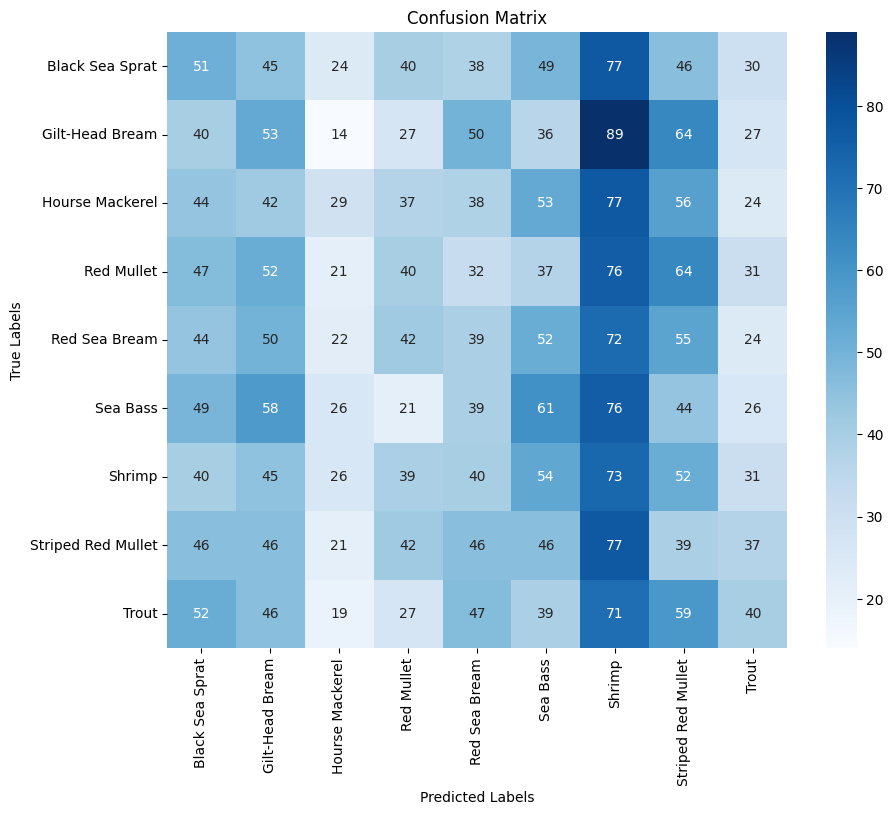

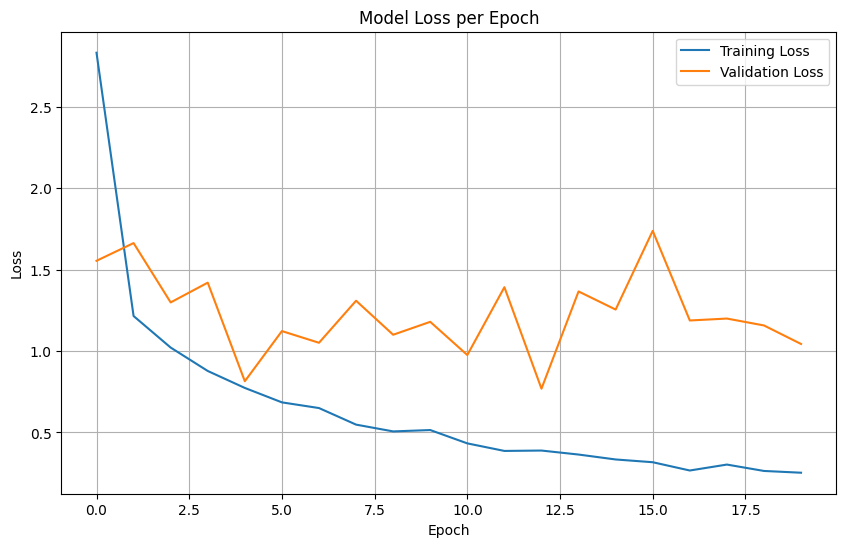

In [13]:
# Predict the labels for validation data
val_predictions = model_ann.predict(validation_generator)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert to label indices

# Get the true labels for the validation data
true_labels = validation_generator.classes

# Get the class labels (fish species names)
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_labels, val_predictions, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, val_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# 0.7244444489479065 validation accuracy is okay but we can do better so lets start working

1. Relu yerine chatgpt LeakyRelu önerdi o yüzden birde bunu deniyorum.
2. 0.3 Dropout Rate eklendi.
3. Epoch sayısını arttırıp Early Stopping Ekledim
4. Overfitting korkusundan buraya birde BatchNormalization ekledim

# SECOND MODEL

In [15]:
# Import required libraries for activation functions
from tensorflow.keras.layers import LeakyReLU

# Build an improved ANN model
model_ann_improved = keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Flatten(),  # Flatten the 3D image to 1D vector
    
    # Add dense layers with improved activation functions and batch normalization
    layers.Dense(512),
    layers.LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),  # Add dropout to prevent overfitting
    
    layers.Dense(256),
    layers.LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    
    layers.Dense(128),
    layers.LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    
    # Output layer with softmax
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_ann_improved.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model_ann_improved.summary()

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Stop training after 5 epochs without improvement
    restore_best_weights=True
)

# Train the model with early stopping
with tf.device('/GPU:0'):
    history = model_ann_improved.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=30,              # Set more epochs since EarlyStopping is used
        batch_size=batch_size,
        callbacks=[early_stopping],  # Apply early stopping
        verbose=2
    )

# Evaluate the improved model
val_loss, val_acc = model_ann_improved.evaluate(validation_generator)
print(f'Improved model validation accuracy: {val_acc}')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_8 (Dense)             (None, 512)               77070848  
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                      

0.8383333086967468 not bad but i wanna try it one more time

DATA VISUALIZATION OF THAT CODE

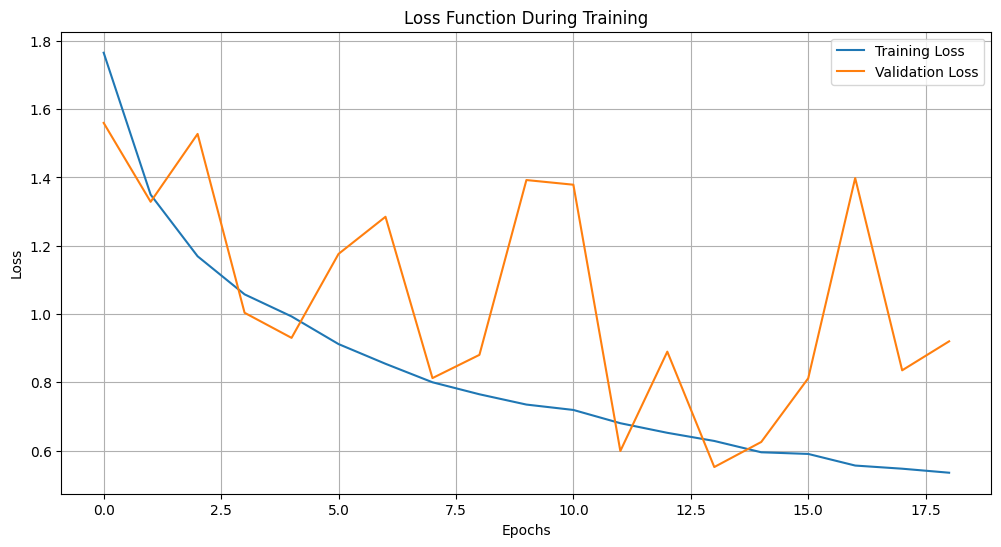

113/113 [==============================] - 41s 363ms/step
Classification Report:
                     precision    recall  f1-score   support

   Black Sea Sprat       0.08      0.08      0.08       400
   Gilt-Head Bream       0.10      0.09      0.09       400
   Hourse Mackerel       0.11      0.10      0.10       400
        Red Mullet       0.12      0.14      0.13       400
     Red Sea Bream       0.11      0.12      0.11       400
          Sea Bass       0.13      0.17      0.15       400
            Shrimp       0.13      0.17      0.14       400
Striped Red Mullet       0.13      0.08      0.10       400
             Trout       0.11      0.10      0.11       400

          accuracy                           0.11      3600
         macro avg       0.11      0.11      0.11      3600
      weighted avg       0.11      0.11      0.11      3600



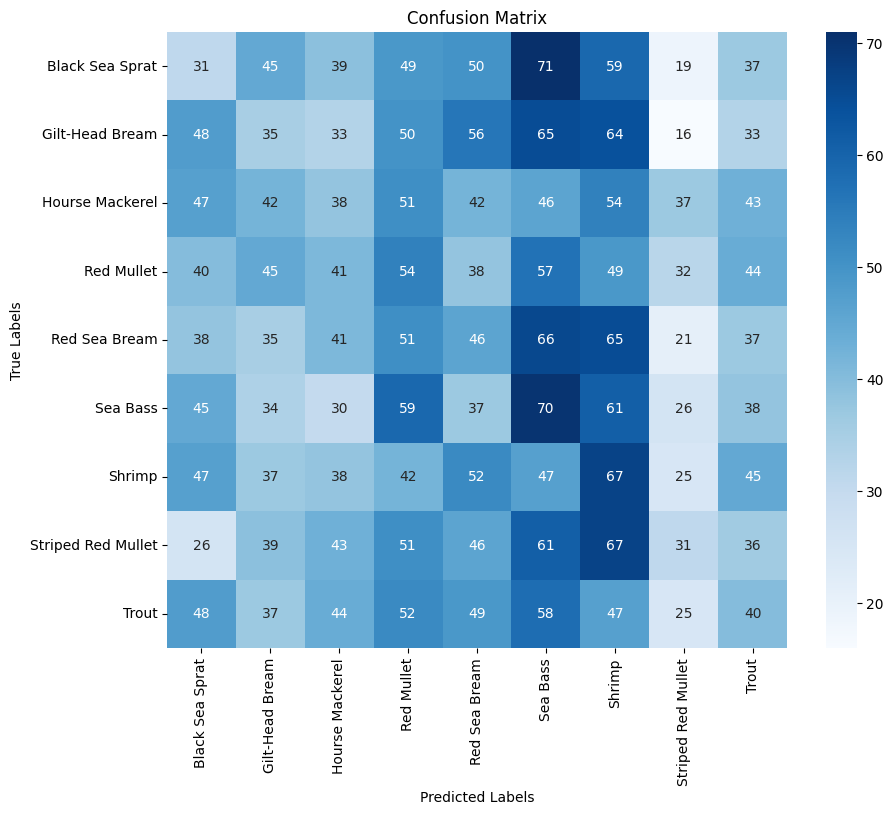

In [16]:
# Plot the loss function
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate predictions for validation data
y_pred = model_ann_improved.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


I didnt like leakyRelu so i am using relu again.
I added one more layer and increase the model complexity.

# THIRD MODEL

In [17]:
# Build an improved ANN model
model_ann_improved = keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Flatten(),  # Flatten the 3D image to 1D vector
    
    # Add dense layers with improved activation functions and batch normalization
    layers.Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Add dropout to prevent overfitting
    
    layers.Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    layers.Dense(256 , activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    layers.Dense(128 , activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Output layer with softmax
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_ann_improved.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model_ann_improved.summary()

#Reduce the learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Stop training after 5 epochs without improvement
    restore_best_weights=True
)

# Train the model with early stopping
with tf.device('/GPU:0'):
    history = model_ann_improved.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=30,              # Set more epochs since EarlyStopping is used
        batch_size=batch_size,
        callbacks=[early_stopping],  # Apply early stopping
        verbose=2
    )

# Evaluate the improved model
val_loss, val_acc = model_ann_improved.evaluate(validation_generator)
print(f'Improved model validation accuracy: {val_acc}')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 dense_12 (Dense)            (None, 1024)              154141696 
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                     

New validation accuracy: 0.7666666507720947 it didnt improve :(  I think we can go with the second model.

DATA VISUALIZATION OF THAT CODE

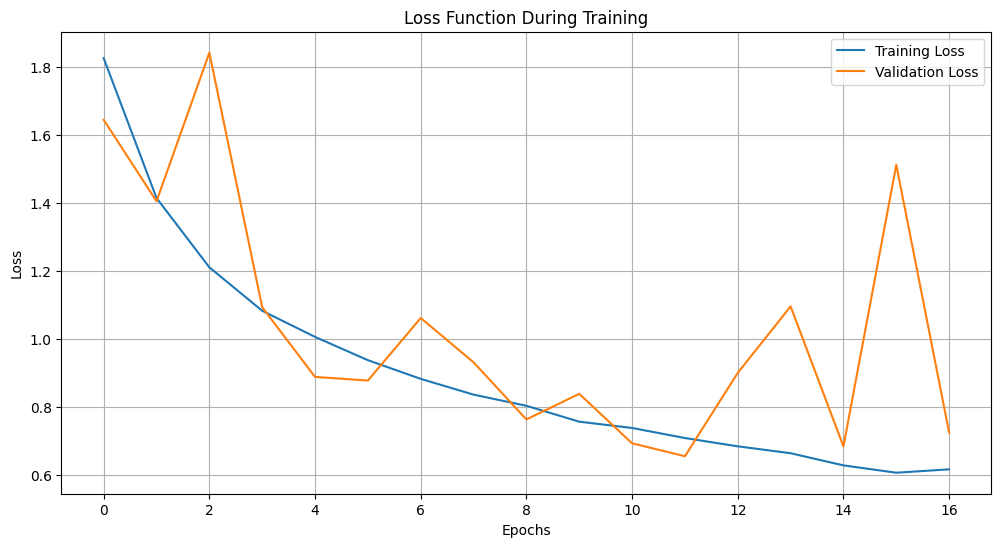

113/113 [==============================] - 43s 378ms/step
Classification Report:
                     precision    recall  f1-score   support

   Black Sea Sprat       0.12      0.14      0.13       400
   Gilt-Head Bream       0.10      0.10      0.10       400
   Hourse Mackerel       0.11      0.10      0.11       400
        Red Mullet       0.11      0.09      0.10       400
     Red Sea Bream       0.11      0.17      0.13       400
          Sea Bass       0.09      0.09      0.09       400
            Shrimp       0.13      0.15      0.14       400
Striped Red Mullet       0.09      0.09      0.09       400
             Trout       0.14      0.07      0.10       400

          accuracy                           0.11      3600
         macro avg       0.11      0.11      0.11      3600
      weighted avg       0.11      0.11      0.11      3600



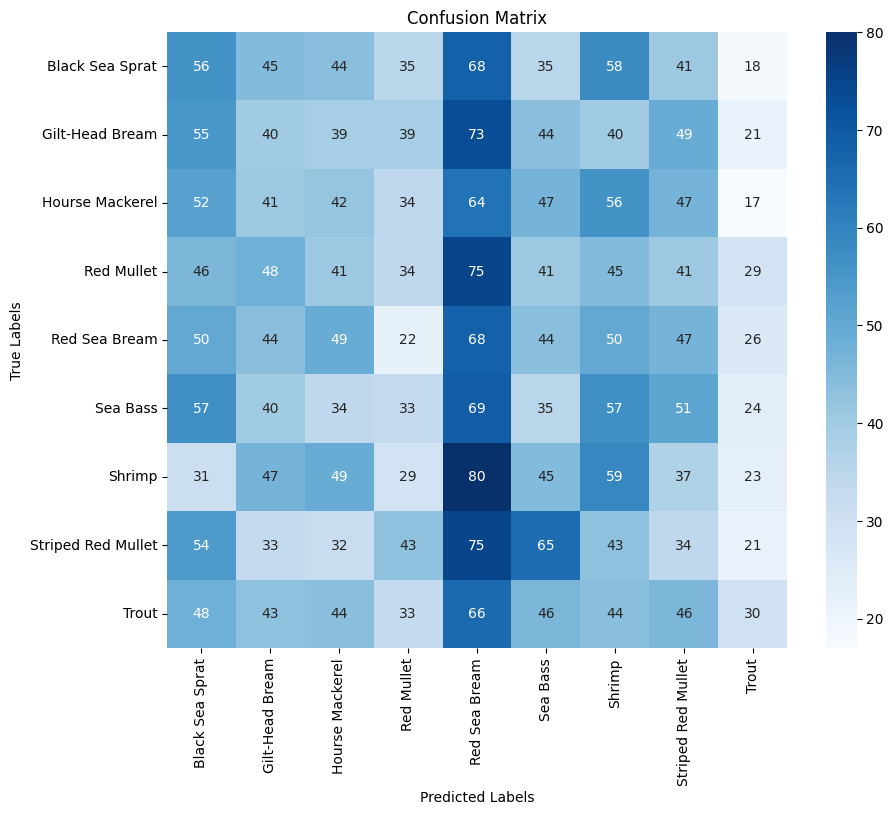

In [18]:
# Plot the loss function
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate predictions for validation data
y_pred = model_ann_improved.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

CHATGPT said if your image classification with many classes has a 70%–85%+ validation accuracy is usually considered successful.So i try to not overfit the model but achieve whats best.

**An epoch takes 7 minutes without using GPU and 2 minutes with GPU, so I wanted to prepare a model that works quickly using mobileNetV2. Finally, we will see which one works best with graphics.**

We can also call this part hyperparameter optimization because I will change the batch size.

# FOURTH MODEL

In [19]:
batch_size = 64  # Increase batch size from 32 to 64
# Load pre-trained MobileNetV2 without top layers
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,  # Exclude the top fully connected layers
    weights='imagenet'  # Use ImageNet weights
)

# Freeze the base model's layers to prevent re-training
base_model.trainable = False

# Add custom top layers
model_transfer = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Convert 3D to 1D
    layers.Dense(512, activation='relu'),
    Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_transfer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model_transfer.summary()

# Train the model
history_transfer = model_transfer.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Transfer learning typically requires fewer epochs
    batch_size=batch_size,
    verbose=1
)




9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_17 (Dense)            (None, 512)               655872    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 9)                 4617      
                                                         

İt gave so high accuracies compared to what i created so is this normal in pretrained models?If you could answer it i would appreciate it.

In [20]:
# Evaluate the improved model
val_loss, val_acc = model_transfer.evaluate(validation_generator)
print(f'Improved model validation accuracy: {val_acc}')

113/113 [==============================] - 43s 379ms/step - loss: 0.2965 - accuracy: 0.9383
Improved model validation accuracy: 0.9383333325386047


0.9383333325386047 accuracy.It gave so high accuracies it looks like it overfits

* **it overfits.
* In the first few epochs, both the training and validation accuracies improve, but starting around Epoch 5, the validation loss fluctuates and even increases (e.g., from 0.1695 in Epoch 4 to 0.3572 in Epoch 5), while the training accuracy keeps improving (0.8295 to 0.9558). This widening gap between the training accuracy and validation accuracy, along with the increase in validation loss, suggests that the model is learning patterns specific to the training data that don't generalize well to the validation set.

DATA VISUALIZATION OF THAT CODE

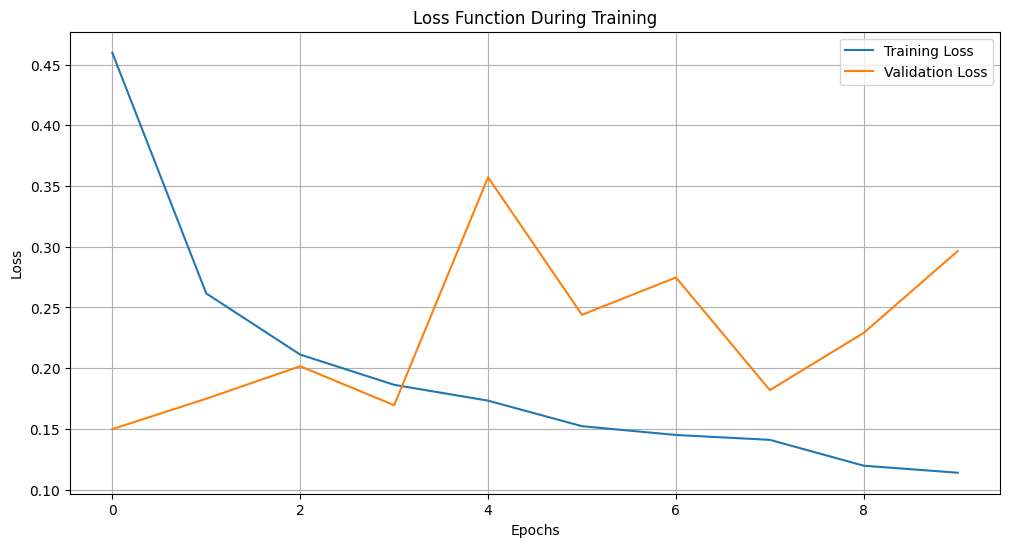

113/113 [==============================] - 43s 376ms/step
Classification Report:
                     precision    recall  f1-score   support

   Black Sea Sprat       0.09      0.09      0.09       400
   Gilt-Head Bream       0.10      0.10      0.10       400
   Hourse Mackerel       0.12      0.10      0.11       400
        Red Mullet       0.10      0.11      0.11       400
     Red Sea Bream       0.10      0.10      0.10       400
          Sea Bass       0.09      0.09      0.09       400
            Shrimp       0.13      0.14      0.14       400
Striped Red Mullet       0.13      0.12      0.12       400
             Trout       0.13      0.14      0.13       400

          accuracy                           0.11      3600
         macro avg       0.11      0.11      0.11      3600
      weighted avg       0.11      0.11      0.11      3600



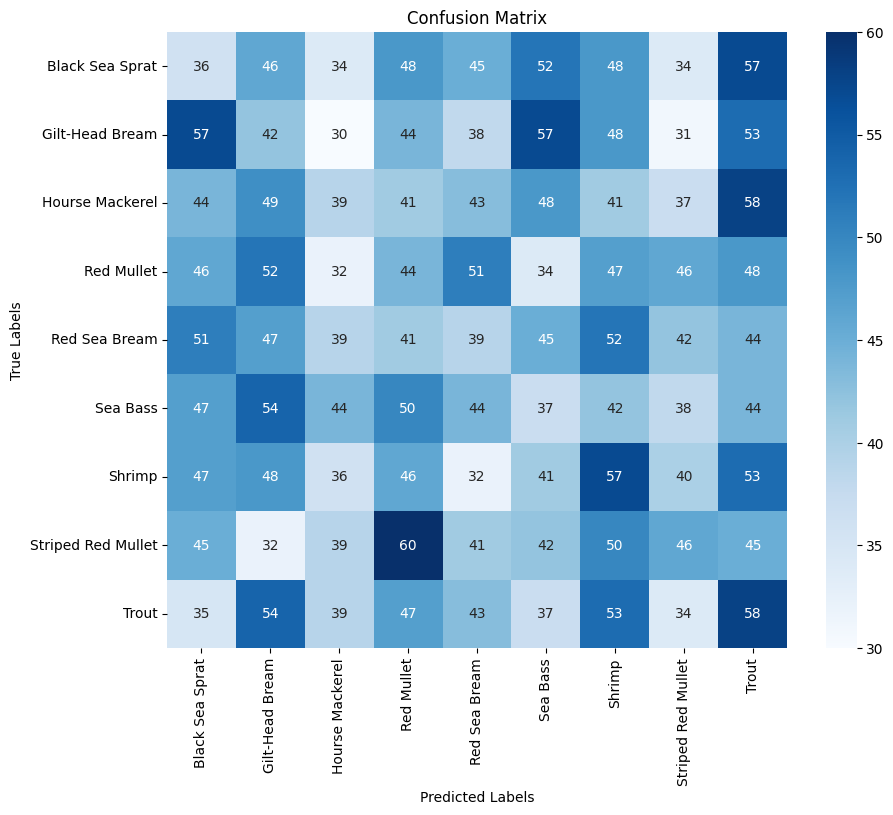

In [21]:
# Plot the loss function
plt.figure(figsize=(12, 6))
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Loss Function During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate predictions for validation data
y_pred = model_transfer.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()